In [1]:
import numpy as np
import cv2
import os

import matplotlib.pyplot as plt
%matplotlib inline

###  Define handy functions

**Useful vis function**

In [2]:
def show_image(orig_img, processed_img):
    fig, ax = plt.subplots(1, 2, figsize=(20, 20))
    _ = ax[0].axis('off')
    _ = ax[0].imshow(orig_img)
    _ = ax[1].axis('off')
    _ = ax[1].imshow(processed_img, cmap='gray')
    plt.show()

**Bounding boxes for objects**

In [3]:
bboxes = [
   (60,10,400,309),
   (61,31,400,295),
   (70,85,240,450),
   (50,45,250,230),
   (120,70,420,200),
   (35,25,440,220),
]

**Object segmentation itself**

In [360]:
def object_segmentation(img, is_cat=False, bbox=None): 
    
    # technical variables for grabCut
    background = np.zeros((1,65), np.float64)
    foreground = np.zeros((1,65), np.float64)
        
    # apply special processing if it's image with cat
    if is_cat:
        # initizlize mask
        mask = np.ones(img.shape[:2], np.uint8)*2

        # get more suitable color space
        img_yuv = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,1]

        # apply blur
        blurred = cv2.GaussianBlur(img_yuv, (7, 7), 3)

        # roi for cat
        mask[150:400, 100:240] = 1
        _, mask_ = cv2.threshold(blurred, 240, 1, type=cv2.THRESH_BINARY)
        mask[mask_] = 1

        # out of bounds
        mask[:, bbox[2]:] = 0
        mask[:, :bbox[0]] = 0

        # apply grabcut
        cv2.grabCut(img, mask, None, background, foreground, 5, cv2.GC_INIT_WITH_MASK)
    
    else:
        # initialize mask
        mask = np.zeros_like(img[:, :, 0])
    
        # perform grubCut
        cv2.grabCut(img, mask, bbox, background, foreground, 5, cv2.GC_INIT_WITH_RECT)
    
    # postprocess mask
    mask = np.where((mask==2)|(mask==0), 0, 1).astype('uint8')
    mask = mask[:, :, np.newaxis]
    
    return mask


In [361]:
for root, dir, files in os.walk('./data/objects/'):
    img_paths = [os.path.join(root, file) for file in files]

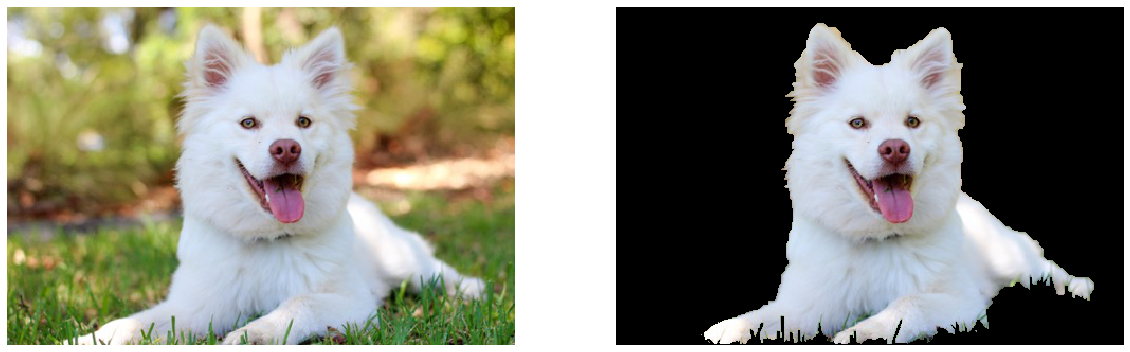

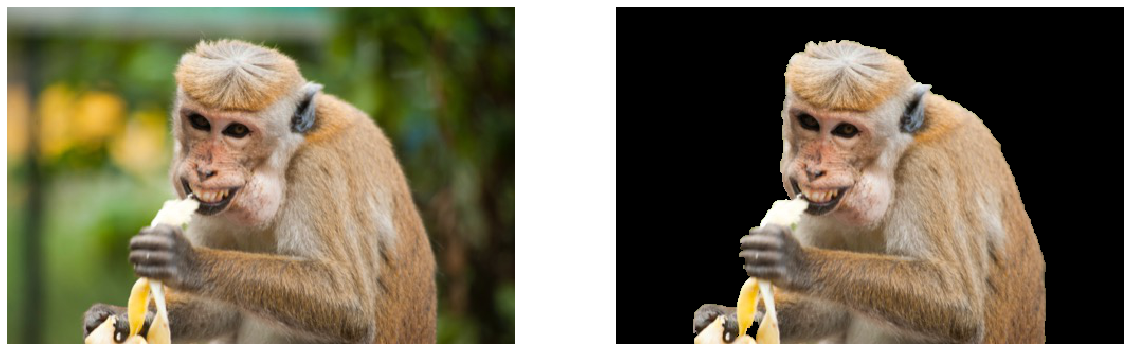

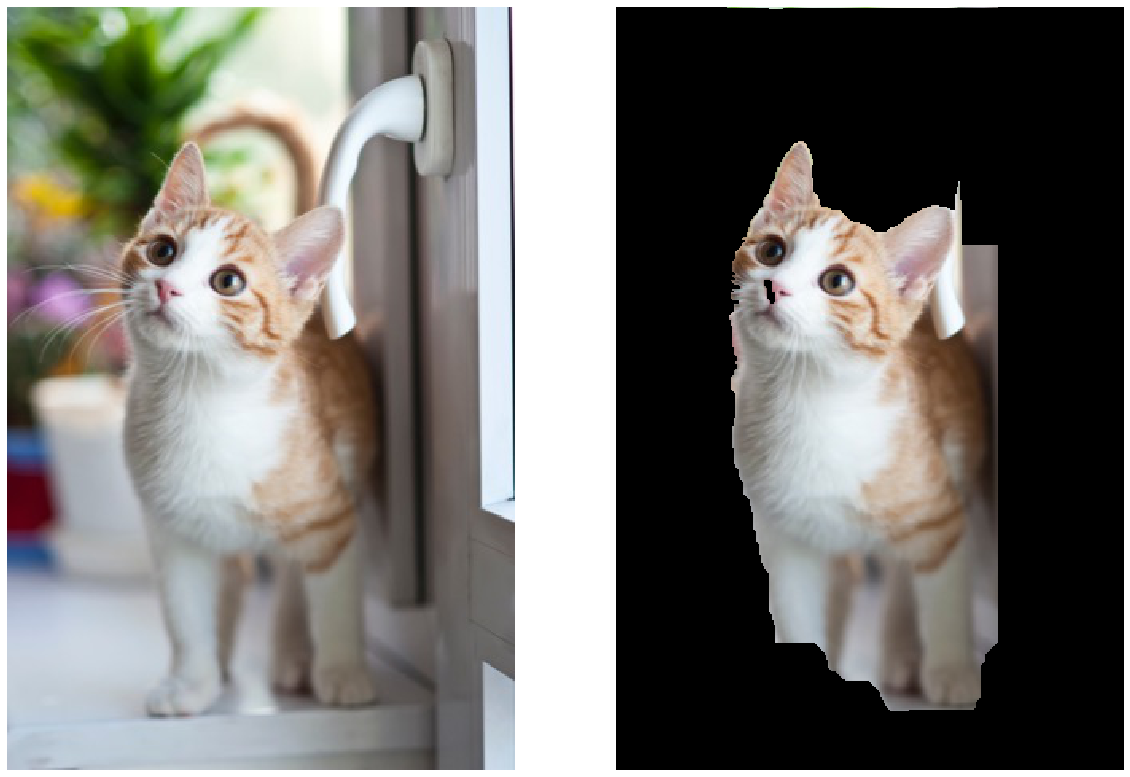

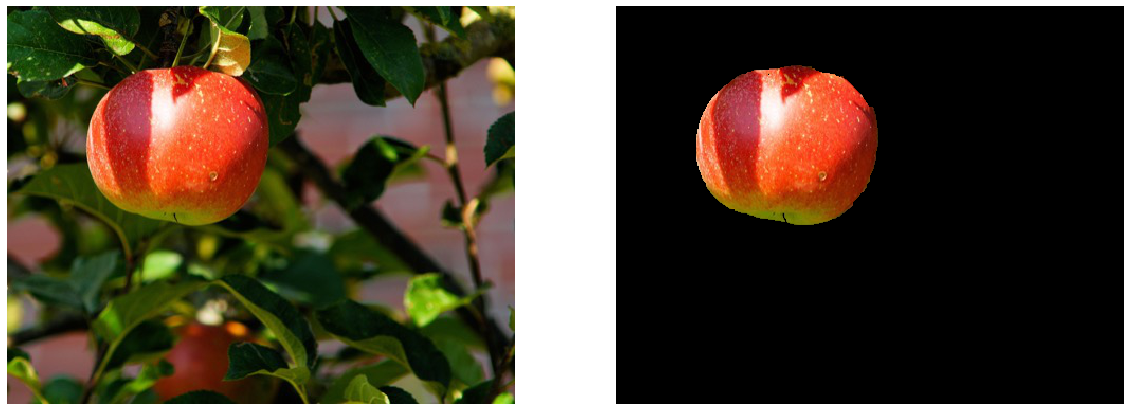

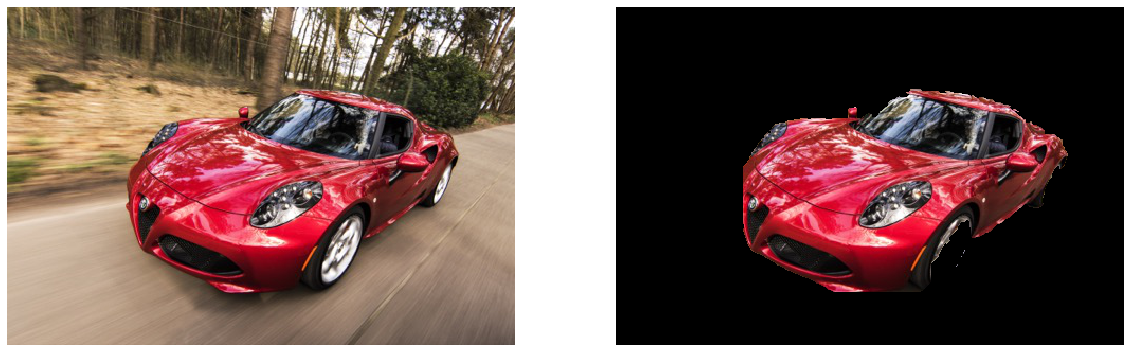

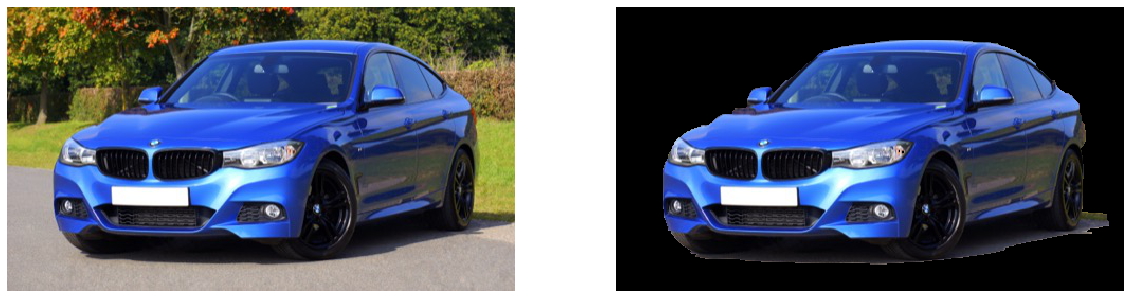

In [362]:
for img_path, bbox in zip(img_paths, bboxes):
    
    # read image
    img = cv2.imread(img_path)
    
    # get original image in RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # get segmented object mask
    if 'obj6' in img_path:
        mask = object_segmentation(img, is_cat=True, bbox=bbox)
    else:
        mask = object_segmentation(img, is_cat=False, bbox=bbox)
    
    # segmented object
    segmented_img = img*mask
    
    # show results
    show_image(img, segmented_img)